### training
* total_batch:32 
* gradient_accum: 2
* max_grad_norm: 1
* warmup_proportition: 0.1
* max_seq_len: 512
* initial learning_rate: 2e-5

In [ ]:
import os
import logging
from transformers import AutoTokenizer, AutoModel, BertTokenizer
#from pytorch_pretrained_bert.optimization import BertAdam
from transformers import AdamW, get_linear_schedule_with_warmup
import torch

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
ROOT_DIR = '/'.join(os.getcwd().split('/')[:-1])
os.chdir(ROOT_DIR)
from modeling.modeling_utils import *
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
import json
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32
EVAL_BATCH = 2
MAX_GRAD_NORM = 1
GRADIENT_ACCUMULATION_STEPS = 2
if GRADIENT_ACCUMULATION_STEPS > 1 :
    BATCH_SIZE = int(BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS)
NUM_TRAIN_EPOCHS = 3
WARMUP_PROPORTION = 0.1
local_rank = -1
no_cuda = False
seed = 2022
output_dir = f'{ROOT_DIR}/readmission_final/'
os.makedirs(output_dir, exist_ok=True)
local_test = False
## model folder named 'pretraining' should be in the root folder


def get_data_loader(features, max_seq_length, batch_size, shuffle=True, add_sampler=False): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    if add_sampler == True:
        logger.info('add sampler')
        if local_rank == -1:
            sampler = SequentialSampler(data)
        else:
            sampler = DistributedSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=EVAL_BATCH)
    else:
        dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

def train(Classifier, NUM_TRAIN_EPOCHS):
    total_train_loss_history = []
    total_val_loss_history = []
    total_learning_rate = []
     
    for real_epoch in trange(int(NUM_TRAIN_EPOCHS)):
        Classifier.train()
        tr_loss_epoch, train_loss_history, learning_rate_list, Classifier = train_one_epoch(Classifier, real_epoch)
        total_train_loss_history.extend(train_loss_history)
        total_learning_rate.extend(learning_rate_list)
        result, loss_history = evaluate(epoch, Classifier)
        total_val_loss_history.extend(loss_history)
        logging.info(result)
        model_name = f'clinicalbert_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}_{str(real_epoch)}.pt'
        torch.save(Classifier.state_dict(), f'{output_dir}{model_name}')
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.plot(total_train_loss_history)
    plt.plot(total_val_loss_history)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


def train_one_epoch(Classifier, epoch):
    global_step = 0 
    global_step_check = 0
    no_improvement = 0
    train_loss_history = []
    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
    Classifier.zero_grad()
    for step, batch in enumerate(train_dataloader):
        Classifier.to(device)
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        #with torch.set_grad_enabled(True):
        loss, logits = Classifier(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        if n_gpu > 1:
            loss = loss.mean() # mean() to average on multi-gpu.
        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS
        loss.backward() 
        train_loss_history.append(loss.item())
        tr_loss += loss.item()
        if ((step + 1) % GRADIENT_ACCUMULATION_STEPS == 0  or (step+1) == len(train_dataloader)):
            torch.nn.utils.clip_grad_norm_(Classifier.parameters(), MAX_GRAD_NORM)  
            optimizer.step()
            scheduler.step()
            Classifier.zero_grad()
            global_step += 1
        if (step+1) % 200 == 0:
            logging_str =  "***** epoch [{}]".format(epoch)
            logging_str += " global_step [{}]".format(global_step) 
            logging_str += " train loss [{}]".format(loss.item())  
            logging.info(logging_str)
        nb_tr_steps = nb_tr_steps + 1
    tr_loss_epoch = tr_loss / nb_tr_steps
    learning_rate_list = scheduler.get_lr()
    return tr_loss_epoch, train_loss_history, learning_rate_list, Classifier
            
            
def evaluate(epoch, Classifier):
    nb_eval_examples = 0
    nb_eval_steps = 0
    m = nn.Sigmoid()
    Classifier.eval()
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []   
    loss_history = []
    dev_example = processor.get_dev_examples(f'{ROOT_DIR}/data/3days/')
    
    dev_features = convert_examples_to_features(
            dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)

    dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
    for step, batch in enumerate(dev_dataloader): 
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        with torch.no_grad():
            tmp_eval_loss, temp_logits = Classifier(input_ids, attention_mask=input_mask,
                                    token_type_ids=segment_ids, labels=label_ids)
            logits = Classifier(input_ids,segment_ids,input_mask) # we don't need twice
        
        logits = torch.squeeze(m(logits)).detach().cpu().numpy()    
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)    
        
        true_labels += list(label_ids)
        pred_labels += list(outputs)
        logits_history = logits_history + logits.flatten().tolist()
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        loss_history.append(tmp_eval_loss.item())
        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
            
    logging_str =  "***** epoch [{}]".format(epoch)
    logging_str += " {} [{:.4}]".format('val_loss', eval_loss)
    
    df_test = pd.read_csv(f'{ROOT_DIR}/data/3days/val.csv')
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, output_dir)
    pr_auc = pr_curve_plot(df_test['Label'].values, logits_history, output_dir)
    rp80 =  vote_pr_curve(df_test, logits_history, output_dir)
    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,  
              'training loss': tr_loss_epoch,
              'AUROC': roc_auc,
              'AUPRC' : pr_auc,
              'RP80': rp80}    
    
    return result, loss_history
 

In [2]:
from bert_utils import BertForSequenceClassification
from transformers.optimization import get_linear_schedule_with_warmup
import json
local_rank  = 0
local_test = False
LEARNING_RATE=2e-05
file_path = f"{ROOT_DIR}/secrets.json"
original_bert = False
if local_test:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
else:
    with open(file_path, "r") as json_file:
        json_data = json.load(json_file)
        proxies = json_data['proxies']
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', proxies=proxies) 
processors = {
    "readmission": readmissionProcessor
}
processor = processors['readmission']()
label_list = processor.get_labels()

train_examples = processor.get_train_examples(f'{ROOT_DIR}/data/3days/')
test_example = processor.get_test_examples(f'{ROOT_DIR}/data/3days/')
dev_example = processor.get_dev_examples(f'{ROOT_DIR}/data/3days/')
train_features = convert_examples_to_features(
        train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_features(
        test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
dev_features = convert_examples_to_features(
        dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)

if local_rank == -1 or no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", 1)
    n_gpu = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)
MAX_GRAD_NORM = 1
GRADIENT_ACCUMULATION_STEPS = 2
#for MAX_GRAD_NORM in [1, 2, 4]:
    # for BATCH_SIZE in [16, 32]:
    #     for GRADIENT_ACCUMULATION_STEPS in [1, 2, 4]:
    for LEARNING_RATE in [2e-5]:
        ## number of loss backward? 
        torch.cuda.empty_cache()
        num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)   
        num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)
        if original_bert:
            Classifier =  AutoModel.from_pretrained('bert-base-uncased', proxies=proxies) 
        else:
            Classifier = BertForSequenceClassification.from_pretrained(os.path.join(f'{ROOT_DIR}/', 'pretraining'), 1)
        # check_points = list(filter(lambda x: '.pt' in x, os.listdir(output_dir)))
        # if len(check_points) > 0:
        #     model_path = output_dir + check_points[0]
        #     print('@@@@@@')
        #     print(model_path)
        #     Classifier.load_state_dict(torch.load(model_path))

        Classifier.to(device)
        param_optimizer = list(Classifier.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(
                nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=LEARNING_RATE, correct_bias=False)

        scheduler = get_cosine_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
        NUM_TRAIN_EPOCHS = 1
        total_train_loss_history = []
        total_val_loss_history = []
        total_learning_rate = []
        m = nn.Sigmoid()
        for real_epoch in trange(int(NUM_TRAIN_EPOCHS)):
            Classifier.train()
            tr_loss_epoch, train_loss_history, learning_rate_list, Classifier = train_one_epoch(Classifier, real_epoch)
            total_train_loss_history.extend(train_loss_history)
            total_learning_rate.extend(learning_rate_list)
            result, loss_history = evaluate(real_epoch, Classifier)
            result['model'] = 'clinicalbert'
            result['epoch'] = real_epoch
            result['batch_size'] = BATCH_SIZE
            result['MAX_GRAD_NORM'] = MAX_GRAD_NORM
            result['GRADIENT_ACCUMULATION_STEPS'] = GRADIENT_ACCUMULATION_STEPS
            result['MAX_SEQ_LENGTH'] = MAX_SEQ_LENGTH
            result['LEARNING_RATE'] = LEARNING_RATE
            total_val_loss_history.extend(loss_history)
            logging.info(result)
            from csv import DictWriter
            headersCSV = list(result.keys())
            with open('result_20220504.csv', 'a', newline='') as f:
                dictwriter_object = DictWriter(f, fieldnames=headersCSV)
                dictwriter_object.writerow(result)
            model_name = f'clinical_bert_BATCH_SIZE_{BATCH_SIZE}_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}_{str(real_epoch)}.pt'
            torch.save(Classifier.state_dict(), f'{output_dir}{model_name}')



in the modeling class


05/04/2022 13:03:32 - INFO - modeling.modeling_utils -   LOOKING AT /home/x1112373/clinicalBERT/CS598-project/data/3days/train.csv
Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
05/04/2022 13:03:33 - INFO - modeling.modeling_utils -   *** Example ***
05/04/2022 13:03:33 - INFO - modeling.modeling_utils -   guid: train-0
05/04/2022 13:03:33 - INFO - modeling.modeling_utils -   tokens: [CLS] have a significant family history of cancer . occupation : drugs : tobacco : alcohol : other : ( per om ##r ) : the patient is a previous mechanical engineer . he smoked occasionally but quit 35 years ago . he denies any alcohol use . lives alone and is independent . no close relatives in the area . siblings in . review of systems : flows ##hee ##t data as of 10 : 26 pm vital signs hem ##od ##yna ##mic monitoring fluid balance 24 hours since am t ##max : 6 c ( 8 tc ##

Max Sequence Length: 1016


05/04/2022 13:04:46 - INFO - modeling.modeling_utils -   *** Example ***
05/04/2022 13:04:46 - INFO - modeling.modeling_utils -   guid: val-0
05/04/2022 13:04:46 - INFO - modeling.modeling_utils -   tokens: [CLS] 10 : 11 pm chest ( pre - op pa & la ##t ) clip # reason : corona ##ry artery disease admitting diagnosis : corona ##ry artery disease medical condition : 77 year old woman with reason for this examination : pre - op final report indication : 77 year old pre - op for cab ##g . technique : pa and lateral radio ##graphs . comparison : findings : the heart is enlarged . there are bilateral pl ##eur ##al e ##ff ##usions , right greater than left with associated minor ate ##le ##cta ##tic changes at the lung bases . the pulmonary va ##scu ##lat ##ure appears somewhat prominent with an upper zone redistribution . there is no p ##ne ##um ##otho ##ra ##x . the patient has had a prior cab ##g with unchanged appearance of median stern ##oto ##my wires . surgical clips are also seen overl

Max Sequence Length: 807
Max Sequence Length: 869


05/04/2022 13:04:55 - INFO - bert_utils -   loading archive file /home/x1112373/clinicalBERT/CS598-project/pretraining
05/04/2022 13:04:55 - INFO - bert_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]05/04/2022 13:06:52 - INFO - root -   ***** epoch [0] global_step [100] train loss [0.35020482540130615]
05/04/2022 13:08:44 - INFO - root -   ***** epoch [0] global

Max Sequence Length: 869


05/04/2022 13:35:30 - INFO - numexpr.utils -   Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
05/04/2022 13:35:30 - INFO - numexpr.utils -   Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
05/04/2022 13:35:30 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.
05/04/2022 13:35:31 - INFO - root -   {'eval_loss': 0.7086655272768987, 'eval_accuracy': 0.5916175961205403, 'training loss': 0.3187195547348963, 'AUROC': 0.6490587577743159, 'AUPRC': 0.6521855146904747, 'RP80': 0.041811846689895474, 'model': 'clinicalbert', 'epoch': 0, 'batch_size': 16, 'MAX_GRAD_NORM': 1, 'GRADIENT_ACCUMULATION_STEPS': 2, 'MAX_SEQ_LENGTH': 512, 'LEARNING_RATE': 2e-05}


Recall at Precision of 80 is {} 0.041811846689895474


100%|██████████| 1/1 [30:30<00:00, 1830.96s/it]


In [18]:
f'{output_dir}{model_name}'

'/home/x1112373/clinicalBERT/CS598-projectoutput3/clinical_bert_BATCH_SIZE_16_LEARNING_RATE_2e-05_gradient_accu_2_MAX_GRAD_NORM_1_0.pt'

### evaluation
- ```{ROOT_PATH}/final_model/clinical_bert_BATCH_SIZE_16_LEARNING_RATE_2e-05_gradient_accu_2_MAX_GRAD_NORM_1_0.pt```

In [13]:
test_features = convert_examples_to_features(test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
test_2_example = processor.get_test_examples(f'{ROOT_DIR}/data/2days/')
test_2days_features = convert_examples_to_features(test_2_example, label_list, MAX_SEQ_LENGTH, tokenizer)
test_2days_dataloader = get_data_loader(test_2days_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
 

05/04/2022 13:43:21 - INFO - modeling.modeling_utils -   *** Example ***
05/04/2022 13:43:21 - INFO - modeling.modeling_utils -   guid: test-0
05/04/2022 13:43:21 - INFO - modeling.modeling_utils -   tokens: [CLS] sin ##us ta ##chy ##card ##ia . generalized low voltage . delayed r wave progression with late pre ##cor ##dial q ##rs transition . findings are non - specific . clinical correlation is suggested . since the previous tracing of same date sin ##us ta ##chy ##card ##ia rate is faster . tracing # 1 sin ##us rhythm . delayed r wave progression with late pre ##cor ##dial q ##rs transition . generalized low q ##rs voltage . findings are non - specific . clinical correlation is suggested . since the previous tracing of the rate is faster and voltage is lower . title : 45 y / o man with h ##x of et ##oh ci ##rr ##hosis who arrived for planned liver transplant . went to or am and received pt from or approx 1800 int ##uba ##ted and se ##date ##d on prop ##of ##ol . transplant , liver a

Max Sequence Length: 807


Epoch: 002, Train loss: 0.6736, Test loss: 0.6150


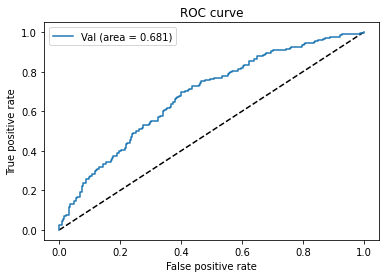

accuracy
0.6149604852049255
Recall at Precision of 80 is {} 0.06844106463878327
-------


<Figure size 432x288 with 0 Axes>

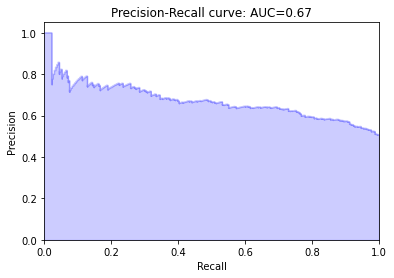

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
correct = 0
eval_loss = 0
eval_accuracy = 0
nb_eval_steps = 0
nb_eval_examples = 0
pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
Classifier.eval()
for step, batch in enumerate(tqdm(test_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        tmp_eval_loss, temp_logits = Classifier(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
        logits = Classifier(input_ids,segment_ids,input_mask) # we don't need twice

    logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
    label_ids = np.array(np.array(label_ids.to('cpu')))
    outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
    tmp_eval_accuracy=np.sum(outputs == label_ids)


    pred_labels += list(outputs)
    true_labels += list(label_ids)
    logits_history = logits_history + logits.flatten().tolist()

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps 
eval_accuracy = eval_accuracy / nb_eval_examples
print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
df_test = pd.read_csv('/home/x1112373/clinicalBERT/CS598-project/data/3days/test.csv')
df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
print('accuracy') 
print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
vote_pr_curve(df_test, logits_history, 'tmp')
print('-------')

Evaluation iteration: 100%|██████████| 2027/2027 [01:45<00:00, 19.17it/s]


Epoch: 002, Train loss: 0.6606, Test loss: 0.6295


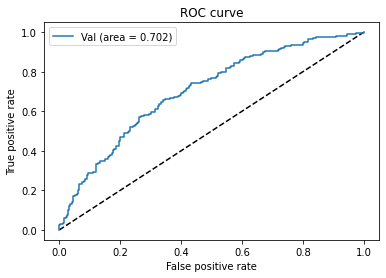

accuracy
0.6295017266896892
Recall at Precision of 80 is {} 0.06204379562043796
-------


<Figure size 432x288 with 0 Axes>

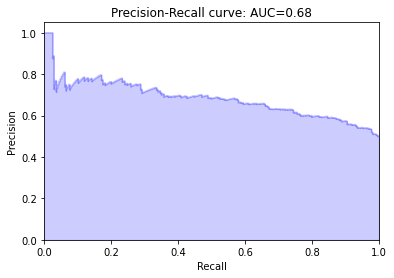

In [14]:
correct = 0
eval_loss = 0
eval_accuracy = 0
nb_eval_steps = 0
nb_eval_examples = 0
pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
Classifier.eval()
for step, batch in enumerate(tqdm(test_2days_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        tmp_eval_loss, temp_logits = Classifier(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
        logits = Classifier(input_ids,segment_ids,input_mask) # we don't need twice

    logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
    label_ids = np.array(np.array(label_ids.to('cpu')))
    outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
    tmp_eval_accuracy=np.sum(outputs == label_ids)


    pred_labels += list(outputs)
    true_labels += list(label_ids)
    logits_history = logits_history + logits.flatten().tolist()

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps 
eval_accuracy = eval_accuracy / nb_eval_examples
print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
df_test = pd.read_csv('/home/x1112373/clinicalBERT/CS598-project/data/2days/test.csv')
df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
print('accuracy') 
print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
vote_pr_curve(df_test, logits_history, 'tmp')
print('-------')

04/25/2022 02:08:53 - INFO - modeling.modeling_utils -   LOOKING AT /home/x1112373/clinicalBERT/CS598-project/data/3days/train.csv
Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
04/25/2022 02:08:54 - INFO - modeling.modeling_utils -   *** Example ***
04/25/2022 02:08:54 - INFO - modeling.modeling_utils -   guid: train-0
04/25/2022 02:08:54 - INFO - modeling.modeling_utils -   tokens: [CLS] have a significant family history of cancer . occupation : drugs : tobacco : alcohol : other : ( per om ##r ) : the patient is a previous mechanical engineer . he smoked occasionally but quit 35 years ago . he denies any alcohol use . lives alone and is independent . no close relatives in the area . siblings in . review of systems : flows ##hee ##t data as of 10 : 26 pm vital signs hem ##od ##yna ##mic monitoring fluid balance 24 hours since am t ##max : 6 c ( 8 tc ##

Max Sequence Length: 1016


04/25/2022 02:10:12 - INFO - modeling.modeling_utils -   *** Example ***
04/25/2022 02:10:12 - INFO - modeling.modeling_utils -   guid: val-0
04/25/2022 02:10:12 - INFO - modeling.modeling_utils -   tokens: [CLS] 10 : 11 pm chest ( pre - op pa & la ##t ) clip # reason : corona ##ry artery disease admitting diagnosis : corona ##ry artery disease medical condition : 77 year old woman with reason for this examination : pre - op final report indication : 77 year old pre - op for cab ##g . technique : pa and lateral radio ##graphs . comparison : findings : the heart is enlarged . there are bilateral pl ##eur ##al e ##ff ##usions , right greater than left with associated minor ate ##le ##cta ##tic changes at the lung bases . the pulmonary va ##scu ##lat ##ure appears somewhat prominent with an upper zone redistribution . there is no p ##ne ##um ##otho ##ra ##x . the patient has had a prior cab ##g with unchanged appearance of median stern ##oto ##my wires . surgical clips are also seen overl

Max Sequence Length: 807
Max Sequence Length: 869


04/25/2022 02:10:23 - INFO - bert_utils -   loading archive file /home/x1112373/clinicalBERT/CS598-project/pretraining
04/25/2022 02:10:23 - INFO - bert_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

  0%|          | 0/3 [00:00<?, ?it/s]04/25/2022 02:14:06 - INFO - root -   ***** epoch [0] global_step [100] train loss [0.33595189452171326]
04/25/2022 02:17:48 - INFO - root -   ***** epoch [0] global_step [200] train loss [0.34436720609664917]
04/25/2022 02:21:30 - INFO - root -   ***** epoch [0] global_step [300] train loss [0.3473544716835022]
04/25/2022 02:25:12 - INFO - root -   ***** epoch [0] global_step [400] train loss [0.34123021364212036]
04/25/2022 02:28:55 - INFO - root -   ***** epoch [0] 

Max Sequence Length: 869


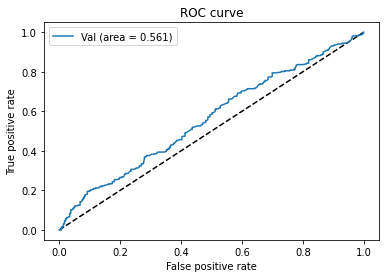

04/25/2022 02:40:42 - INFO - root -   {'eval_loss': 0.6929565477544641, 'eval_accuracy': 0.5171458261170766, 'training loss': 0.3477882410149019, 'AUROC': 0.5610945285464556, 'AUPRC': 0.5665398271168182, 'RP80': 0}


Test Sample too small or RP80=0


 33%|███▎      | 1/3 [30:17<1:00:35, 1817.93s/it]04/25/2022 02:44:25 - INFO - root -   ***** epoch [1] global_step [100] train loss [0.3497031033039093]
04/25/2022 02:48:07 - INFO - root -   ***** epoch [1] global_step [200] train loss [0.35723739862442017]
04/25/2022 02:51:49 - INFO - root -   ***** epoch [1] global_step [300] train loss [0.34362635016441345]
04/25/2022 02:55:31 - INFO - root -   ***** epoch [1] global_step [400] train loss [0.34816497564315796]
04/25/2022 02:59:14 - INFO - root -   ***** epoch [1] global_step [500] train loss [0.3501507639884949]
04/25/2022 03:02:56 - INFO - root -   ***** epoch [1] global_step [600] train loss [0.3410249650478363]
04/25/2022 03:06:38 - INFO - root -   ***** epoch [1] global_step [700] train loss [0.34195658564567566]
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate co

Max Sequence Length: 869


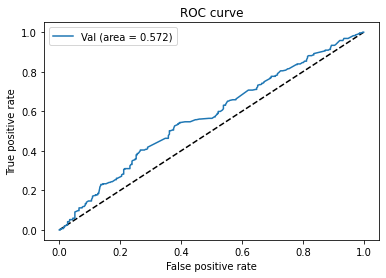

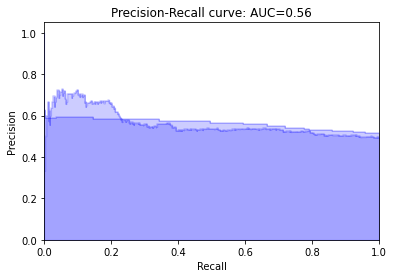

04/25/2022 03:11:01 - INFO - root -   {'eval_loss': 0.6926854927109566, 'eval_accuracy': 0.5171458261170766, 'training loss': 0.34812918800107606, 'AUROC': 0.5718566790738604, 'AUPRC': 0.537247845992652, 'RP80': 0}


Test Sample too small or RP80=0


 67%|██████▋   | 2/3 [1:00:37<30:18, 1818.75s/it]04/25/2022 03:14:44 - INFO - root -   ***** epoch [2] global_step [100] train loss [0.35471707582473755]
04/25/2022 03:18:26 - INFO - root -   ***** epoch [2] global_step [200] train loss [0.350385457277298]
04/25/2022 03:22:08 - INFO - root -   ***** epoch [2] global_step [300] train loss [0.34680798649787903]
04/25/2022 03:25:50 - INFO - root -   ***** epoch [2] global_step [400] train loss [0.3482596278190613]
04/25/2022 03:29:33 - INFO - root -   ***** epoch [2] global_step [500] train loss [0.3444333076477051]
04/25/2022 03:33:15 - INFO - root -   ***** epoch [2] global_step [600] train loss [0.3430035412311554]
04/25/2022 03:36:56 - INFO - root -   ***** epoch [2] global_step [700] train loss [0.3497864902019501]
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate compu

Max Sequence Length: 869


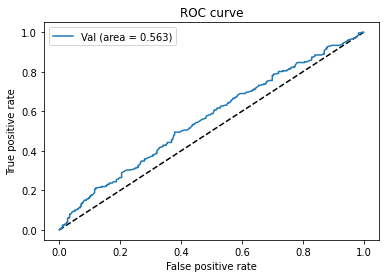

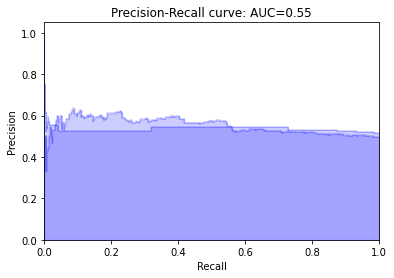

04/25/2022 03:41:19 - INFO - root -   {'eval_loss': 0.6928198764305195, 'eval_accuracy': 0.5171458261170766, 'training loss': 0.3486365825336781, 'AUROC': 0.5633064180471156, 'AUPRC': 0.5536608204981885, 'RP80': 0.003484320557491289}


Recall at Precision of 80 is {} 0.003484320557491289


100%|██████████| 3/3 [1:30:55<00:00, 1818.53s/it]


<Figure size 432x288 with 0 Axes>

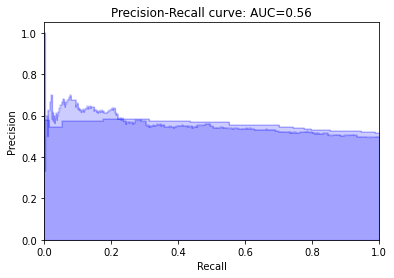

In [10]:
from bert_utils import BertForSequenceClassification
from transformers.optimization import get_linear_schedule_with_warmup
import json
local_rank  = 0
local_test = False
LEARNING_RATE=10e-05
file_path = f"{ROOT_DIR}/secrets.json"
if local_test:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
else:
    with open(file_path, "r") as json_file:
        json_data = json.load(json_file)
        proxies = json_data['proxies']
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', proxies=proxies) 
processors = {
    "readmission": readmissionProcessor
}
processor = processors['readmission']()
label_list = processor.get_labels()

train_examples = processor.get_train_examples(f'{ROOT_DIR}/data/3days/')
test_example = processor.get_test_examples(f'{ROOT_DIR}/data/3days/')
dev_example = processor.get_dev_examples(f'{ROOT_DIR}/data/3days/')
train_features = convert_examples_to_features(
        train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_features(
        test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
dev_features = convert_examples_to_features(
        dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)

if local_rank == -1 or no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", local_rank)
    n_gpu = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)
## number of loss backward? 
num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)   
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)
Classifier = BertForSequenceClassification.from_pretrained(os.path.join(f'{ROOT_DIR}/', 'pretraining'), 1)
Classifier.to(device)
param_optimizer = list(Classifier.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     correct_bias=False)  # To reproduce old BertAdam specific behavior set correct_bias=False

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
NUM_TRAIN_EPOCHS = 3
total_train_loss_history = []
total_val_loss_history = []
total_learning_rate = []
m = nn.Sigmoid()
for real_epoch in trange(int(NUM_TRAIN_EPOCHS)):
    Classifier.train()
    tr_loss_epoch, train_loss_history, learning_rate_list, Classifier = train_one_epoch(Classifier, real_epoch)
    total_train_loss_history.extend(train_loss_history)
    total_learning_rate.extend(learning_rate_list)
    result, loss_history = evaluate(real_epoch, Classifier)
    total_val_loss_history.extend(loss_history)
    logging.info(result)
    model_name = f'clinicalbert_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}_{str(real_epoch)}.pt'
    torch.save(Classifier.state_dict(), f'{output_dir}{model_name}')
   


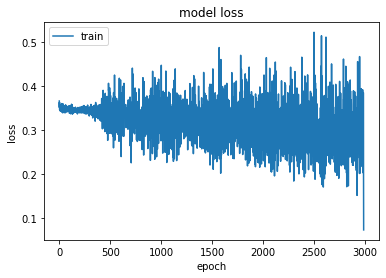

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(total_train_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

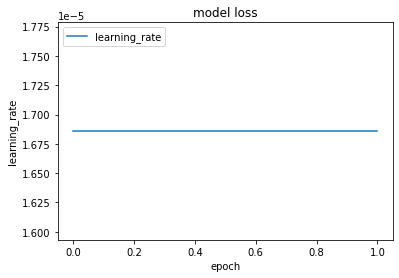

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(total_learning_rate)
plt.title('model loss')
plt.ylabel('learning_rate')
plt.xlabel('epoch')
plt.legend(['learning_rate'], loc='upper left')
plt.show()